### 제주도 도로 교통량 예측 AI 경진대회

#### CatBoost + XGBoost + LGBM Ensemble 모델 (Private 3.08359) (게더타운주민들)

- 어린이보호구역 : https://www.data.go.kr/data/15012891/standard.do
- 무인교통단속카메라 : https://www.data.go.kr/data/15028200/standard.do
- 전국초중등학교기본정보 : https://www.data.go.kr/data/15107734/standard.do
- 제주도 주차장 : https://www.data.go.kr/data/15012896/standard.do

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import gc

from sklearn.preprocessing import LabelEncoder
from haversine import haversine
from sklearn.cluster import KMeans

import math

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

### Data

In [2]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'data/jeju/{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [3]:
csv_to_parquet('data/jeju/train.csv', 'train')
csv_to_parquet('data/jeju/test.csv', 'test')

train Done.
test Done.


In [4]:
train = pd.read_parquet('data/jeju/train.parquet')
test = pd.read_parquet('data/jeju/test.parquet')

# 불필요 컬럼 삭제
train.drop(['vehicle_restricted', 'id', 'height_restricted'], axis = 1, inplace = True)
test.drop(['vehicle_restricted', 'id', 'height_restricted'], axis = 1, inplace = True)

### Feature Engineering

#### 1. 도로 주변 시설 및 구역 수(train 기준)
- 공공 데이터 포털에서 2022년 12월 이전 아래 5가지 표준 데이터를 사용
    - 무인교통단속카메라
    - 전국초중등학교기본정보
    - 어린이보호구역
    - 제주시 주차장 정보
    - 서귀포시 주차장 정보
- train의 start_node, end_node의 위경도 좌표의 unique 값만을 활용

In [5]:
# train의 start_node, end_node의 위경도 좌표의 unique 값
gps_comb = train[['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']].drop_duplicates()

# 무인교통단속카메라 - 데이터 내려감
# cctv = pd.read_csv('경찰청_제주특별자치도경찰청_무인교통단속카메라_20220616.csv', encoding = 'cp949')
# cctv = cctv.iloc[:, 3:-7].drop(['소재지도로명주소', '소재지지번주소'], axis = 1)

# 초중등학교
school = pd.read_csv('data/jeju/한국교육학술정보원_초중등학교기본정보_20221213.csv', encoding = 'cp949')
school = school[(school['데이터기준일자'] <= '2022-12-01') & (school['시도교육청명'].str.contains('제주'))]

# 어린이 보호 구역
child = pd.read_csv('data/jeju/제주특별자치도_어린이보호구역_20221201.csv', encoding = 'cp949')

# 제주시 주차장
parking1 = pd.read_csv('data/jeju/제주특별자치도_제주시_주차장정보_20210818_1630391997093_77385.csv', encoding = 'cp949')
parking1.dropna(subset = ['위도', '경도'], inplace = True)

# 서귀포시 주차장
parking2 = pd.read_csv('data/jeju/제주특별자치도_서귀포시_주차장정보_20221215.csv', encoding = 'cp949')

In [6]:
# 직선과 점 사이의 거리 방정식 활용
def cal_dist(x1, y1, x2, y2, a, b):
    area = abs((x1 - a) * (y2 - b) - (y1 - b) * (x2 - a))
    AB = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
    distance = area / AB
    return distance

In [7]:
# train 데이터의 도로와 각 시설 및 구역의 위경도 좌표의 거리(위경도 좌표상 거리)가 0.0005이내일 경우 count +
def get_node_cnt(gps_values, infra_values):
    cnt = []
    for y1, x1, y2, x2 in gps_values.values:
        i = 0
        for a, b in infra_values.values:
            dist = cal_dist(x1, y1, x2, y2, a, b)
            if dist < 0.0005:
                i += 1
            else:
                pass
        cnt.append(i)
    return cnt

In [8]:
school.head()

,시도교육청코드,시도교육청명,교육지원청코드,교육지원청명,시도코드,시도명,시군구코드,시군구명,학교명,설립형태 구분명,...,교원 수,특수학급 수,소재지도로명주소,소재지지번주소,홈페이지주소,전화번호,팩스번호,남녀공학구분명,공시차수,데이터기준일자
10846,9290000,제주특별자치도교육청,9299000,제주특별자치도서귀포시교육지원청,50,제주특별자치도,130,서귀포시,대정고등학교,공립,...,43,1,제주특별자치도 서귀포시 대정읍 일주서로2498번길 21,NaN,http://daejeong.jje.hs.kr,064-730-0100,064-794-2070,남,202205,2022-05-31
10847,9290000,제주특별자치도교육청,9299000,제주특별자치도서귀포시교육지원청,50,제주특별자치도,130,서귀포시,서귀포온성학교,공립,...,45,2,제주특별자치도 서귀포시 516로 447-10,NaN,http://onseong.jje.sc.kr,064-760-8000,064-767-8014,남녀공학,202205,2022-05-31
10848,9290000,제주특별자치도교육청,9299000,제주특별자치도서귀포시교육지원청,50,제주특별자치도,130,서귀포시,토산초등학교,공립,...,10,0,제주특별자치도 서귀포시 표선면 토산중앙로 68-9,NaN,http://tosan.jje.es.kr,064-780-9200,064-780-9299,남녀공학,202205,2022-05-31
10849,9290000,제주특별자치도교육청,9299000,제주특별자치도서귀포시교육지원청,50,제주특별자치도,130,서귀포시,남원초등학교,공립,...,24,1,제주특별자치도 서귀포시 남원읍 태위로 647,NaN,http://jjnamwon.jje.es.kr,064-766-4100,064-766-4194,남녀공학,202205,2022-05-31
10850,9290000,제주특별자치도교육청,9299000,제주특별자치도서귀포시교육지원청,50,제주특별자치도,130,서귀포시,보성초등학교,공립,...,19,0,제주특별자치도 서귀포시 대정읍 추사로55번길 6-1,NaN,http://jejuboseong.jje.es.kr,064-797-3300,064-797-3399,남녀공학,202205,2022-05-31


In [9]:
# school 데이터도 위도, 경도 제공하지 않기에 제외
# cctv_cnt = get_node_cnt(gps_comb, cctv[['경도', '위도']])
# school_cnt = get_node_cnt(gps_comb, school[['경도', '위도']])
child_cnt = get_node_cnt(gps_comb, child[['경도', '위도']])
parking1_cnt = get_node_cnt(gps_comb, parking1[['경도', '위도']])
parking2_cnt = get_node_cnt(gps_comb, parking2[['경도', '위도']])
parking_cnt = list(np.array(parking1_cnt) + np.array(parking2_cnt))

In [10]:
# gps_comb['CCTV_cnt'] = cctv_cnt
# gps_comb['school_cnt'] = school_cnt
gps_comb['child_cnt'] = child_cnt
gps_comb['parking_cnt'] = parking_cnt

In [11]:
train = pd.merge(train, gps_comb, how = 'left')
test = pd.merge(test, gps_comb, how = 'left').fillna(0)

#### 2. 제주 공항까지 거리(km)
- train과 test의 시작 위경도 좌표와 제주 공항 위경도 좌표까지의 거리(km)

In [12]:
jeju = (33.506683, 126.493177)

In [13]:
train['j_a_dist'] = [haversine((v[0], v[1]), jeju, unit = 'km') for v in train[['start_latitude', 'start_longitude']].values]
test['j_a_dist'] = [haversine((v[0], v[1]), jeju, unit = 'km') for v in test[['start_latitude', 'start_longitude']].values]

#### 3. 한라산까지 거리(km)
- train과 test의 시작 위경도 좌표와 한라산 위경도 좌표까지의 거리(km)

In [14]:
hanla = 33.36168194, 126.5291548

In [15]:
train['h_a_dist'] = [haversine((v[0], v[1]), hanla, unit = 'km') for v in train[['start_latitude', 'start_longitude']].values]
test['h_a_dist'] = [haversine((v[0], v[1]), hanla, unit = 'km') for v in test[['start_latitude', 'start_longitude']].values]

#### 4. start_node_name과 end_node_name을 key값으로 만들어 LabelEncoding

In [16]:
le = LabelEncoder()

In [17]:
train['node_combination'] = train['start_node_name'] + '_' + train['end_node_name']
test['node_combination'] = test['start_node_name'] + '_' + test['end_node_name']

In [18]:
train['node_combination'] = le.fit_transform(train['node_combination'])

In [19]:
for category in np.unique(test['node_combination']) :
    if category not in le.classes_ :
        le.classes_ = np.append(le.classes_, label)
test['node_combination'] = le.transform(test['node_combination'])

#### 5. 위경도 좌표만으로 Clustering(KMeans)
- Clustering Plotting 결과 군집 수가 6일 때 각 좌표가 명확히 구분되어 6으로 설정

In [20]:
km = KMeans(n_clusters = 6, max_iter = 1000, random_state = 42, n_init = 15)

In [21]:
train['gps_cls'] = km.fit_predict(train[['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']])
test['gps_cls'] = km.predict(test[['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']])
# numpy 버전 1.21.4로 다운그레이드하여 문제 해결 ㅜㅜ

#### 6. 공휴일 전후 1 ~ 2일 여부

- 일반적인 공휴일 기준으로 전후 1 ~ 2일을 기간을 더 두어 binary화

In [22]:
train['base_date'] = train['base_date'].astype(str)
test['base_date'] = test['base_date'].astype(str)

In [23]:
train['date'] = train['base_date'].str[4:]
test['date'] = test['base_date'].str[4:]

In [24]:
h_days = ['1231', '0101', '0102', '0129', '0130', '0131', '0201', '0202', '0228', '0229', '0230', '0301', '0302', 
          '0505', '0506', '0507', '0508', '0605', '0607', '0606', '0814', '0815', '0816', '0920', '0921', '0504',
          '0922', '1002', '1003', '1004', '1008', '1009', '1010', '1224', '1225', '1226']

In [25]:
train['in_h_days'] = train['date'].isin(h_days)
test['in_h_days'] = test['date'].isin(h_days)

#### 7. 년도

In [26]:
train['base_date'] = pd.to_datetime(train['base_date'])
test['base_date'] = pd.to_datetime(test['base_date'])

In [27]:
train['year'] = train['base_date'].dt.year
test['year'] = test['base_date'].dt.year

#### 8. 월

In [28]:
train['month'] = train['base_date'].dt.month
test['month'] = test['base_date'].dt.month

#### 9. 최고 제한 속도로 도로 주행시 소요 시간

In [29]:
dist = []
for i, v in enumerate(train[['start_latitude', 'end_latitude', 'start_longitude', 'end_longitude']].values) :
    dist.append(haversine((v[0], v[2]), (v[1], v[3]), unit = 'km'))

In [30]:
train['at_time'] = 60 * pd.Series(dist) / train['maximum_speed_limit']

In [31]:
dist = []
for i, v in enumerate(test[['start_latitude', 'end_latitude', 'start_longitude', 'end_longitude']].values) :
    dist.append(haversine((v[0], v[2]), (v[1], v[3]), unit = 'km'))

In [32]:
test['at_time'] = 60 * pd.Series(dist) / test['maximum_speed_limit']

In [33]:
gc.collect()

18

#### 10. 방위각
- 각 도로의 start, end node의 위경도 좌표로 해당 도로의 방위각 계산

In [34]:
def Azimuth(lat1, lng1, lat2, lng2):
    Lat1 = math.radians(lat1)
    Lat2 = math.radians(lat2)
    Lng1 = math.radians(lng1)
    Lng2 = math.radians(lng2)
    
    y = math.sin(Lng2 - Lng1) * math.cos(Lat2)
    x = math.cos(Lat1) * math.sin(Lat2) - math.sin(Lat1) * math.cos(Lat2) * math.cos(Lng2-Lng1)
    z = math.atan2(y, x)

    a = np.rad2deg(z)
    
    if(a < 0):
        a = 180 + (180 + a)
    return a

In [35]:
train['degree'] = [Azimuth(v[0], v[1], v[2], v[3]) for i, v in enumerate(train[['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']].values)]
test['degree'] = [Azimuth(v[0], v[1], v[2], v[3]) for i, v in enumerate(test[['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']].values)]

#### 11. 계절

In [36]:
def get_season(x) :
    
    if x in [9, 10, 11] :
        return 3
    elif x in [12, 1, 2] :
        return 2
    elif x in [3, 4, 5, 6] :
        return 1
    else :
        return 0

In [37]:
train['season'] = train['month'].apply(get_season)
test['season'] = test['month'].apply(get_season)

#### 12. 요일

- 일반적인 요일 순서대로가 아닌 LabelEncoding으로 진행

In [38]:
train['day_of_week'] = le.fit_transform(train['day_of_week'])

In [39]:
for category in np.unique(test['day_of_week']) :
    if category not in le.classes_ :
        le.classes_ = np.append(le.classes_, label)
test['day_of_week'] = le.transform(test['day_of_week'])

#### 13. 도로명

- 도로명 LabelEncoding

In [40]:
train['road_name'] = le.fit_transform(train['road_name'])

In [41]:
for category in np.unique(test['road_name']) :
    if category not in le.classes_ :
        le.classes_ = np.append(le.classes_, label)
test['road_name'] = le.transform(test['road_name'])

#### 14. 시작 노드 == 종료 노드 여부

In [42]:
train['node_same'] = train['start_node_name'] == train['end_node_name']
test['node_same'] = test['start_node_name'] == test['end_node_name']

#### 15. 기타 컬럼 LabelEncoding

In [43]:
train['start_turn_restricted'] = le.fit_transform(train['start_turn_restricted'])

In [44]:
for category in np.unique(test['start_turn_restricted']) :
    if category not in le.classes_ :
        le.classes_ = np.append(le.classes_, label)
test['start_turn_restricted'] = le.transform(test['start_turn_restricted'])

In [45]:
train['end_turn_restricted'] = le.fit_transform(train['end_turn_restricted'])

In [46]:
for category in np.unique(test['end_turn_restricted']) :
    if category not in le.classes_ :
        le.classes_ = np.append(le.classes_, label)
test['end_turn_restricted'] = le.transform(test['end_turn_restricted'])

In [47]:
# 모델링 사용 제외 컬럼 삭제
train.drop(['start_node_name', 'end_node_name', 'date', 'base_date'], axis = 1, inplace = True)
test.drop(['start_node_name', 'end_node_name', 'date', 'base_date'], axis = 1, inplace = True)

In [51]:
train.to_csv('data/jeju/pre_data/pre_train.csv', encoding = 'utf8') # 파일 저장
test.to_csv('data/jeju/pre_data/pre_test.csv', encoding = 'utf8')

### Modeling

- lane_count를 1, 2, 3으로 나누어 모델링
- LGBM, XGBoost는 optuna로 파라미터 튜닝

In [2]:
train = pd.read_csv('data/jeju/pre_data/pre_train.csv', index_col = 0)
test = pd.read_csv('data/jeju/pre_data/pre_test.csv', index_col = 0)

In [3]:
X = train.drop(['target'], axis = 1)
y = train.target
target = test[X.columns]
skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

X1 = X[X['lane_count'] == 1].drop(['lane_count'], axis = 1)
X2 = X[X['lane_count'] == 2].drop(['lane_count'], axis = 1)
X3 = X[X['lane_count'] == 3].drop(['lane_count'], axis = 1)

y1 = y[X1.index]
y2 = y[X2.index]
y3 = y[X3.index]

standard1 = X1['day_of_week']
standard2 = X2['day_of_week']
standard3 = X3['day_of_week']

target1 = target.loc[target['lane_count'] == 1, X1.columns]
target2 = target.loc[target['lane_count'] == 2, X2.columns]
target3 = target.loc[target['lane_count'] == 3, X3.columns]

#### 1. CatBoost

In [50]:
cb_pred1 = np.zeros(target1.shape[0])
i = 0
cb_mae = []

for tr_idx, val_idx in skf.split(X1, standard1):
    
    tr_x, tr_y = X1.iloc[tr_idx], y1.iloc[tr_idx]
    val_x, val_y = X1.iloc[val_idx], y1.iloc[val_idx]

    cb = CatBoostRegressor(max_depth = 8, learning_rate = 0.033, use_best_model = True, iterations = 10000, eval_metric = 'MAE')

    cb.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], early_stopping_rounds = 5, verbose = 2500)

    val_pred = cb.predict(val_x).astype(int)
    fold_mae = mean_absolute_error(val_y, val_pred)
    cb_mae.append(fold_mae)
    print(f"{i + 1} Fold MAE = {fold_mae}")

    i += 1

    fold_pred = cb.predict(target1) / skf.n_splits
    cb_pred1 += fold_pred

print(f"\nAVG of MAE = {np.mean(cb_mae)}")

0:	learn: 10.7036682	test: 10.7036682	test1: 10.7213488	best: 10.7213488 (0)	total: 201ms	remaining: 33m 29s
2500:	learn: 2.8069726	test: 2.8069726	test1: 2.8396487	best: 2.8396487 (2500)	total: 4m 13s	remaining: 12m 41s
5000:	learn: 2.7276822	test: 2.7276822	test1: 2.7771141	best: 2.7771141 (5000)	total: 8m 14s	remaining: 8m 14s
7500:	learn: 2.6802176	test: 2.6802176	test1: 2.7444068	best: 2.7444068 (7500)	total: 12m 22s	remaining: 4m 7s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 2.727826215
bestIteration = 9377

Shrink model to first 9378 iterations.
1 Fold MAE = 2.7919334762020864
0:	learn: 10.7085999	test: 10.7085999	test1: 10.6935783	best: 10.6935783 (0)	total: 143ms	remaining: 23m 48s
2500:	learn: 2.8080414	test: 2.8080414	test1: 2.8258439	best: 2.8258439 (2500)	total: 3m 24s	remaining: 10m 14s
5000:	learn: 2.7283515	test: 2.7283515	test1: 2.7627244	best: 2.7627244 (5000)	total: 6m 33s	remaining: 6m 33s
7500:	learn: 2.6811667	test: 2.6811667	test1: 2.7310553

In [51]:
np.save('data/jeju/pred/cb_pred1', cb_pred1)

In [52]:
cb_pred2 = np.zeros(target2.shape[0])
i = 0
cb_mae = []

for tr_idx, val_idx in skf.split(X2, standard2):
    
    tr_x, tr_y = X2.iloc[tr_idx], y2.iloc[tr_idx]
    val_x, val_y = X2.iloc[val_idx], y2.iloc[val_idx]

    cb = CatBoostRegressor(max_depth = 8, learning_rate = 0.033, use_best_model = True, iterations = 10000, eval_metric = 'MAE')

    cb.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], early_stopping_rounds = 5, verbose = 2500)

    val_pred = cb.predict(val_x).astype(int)
    fold_mae = mean_absolute_error(val_y, val_pred)
    cb_mae.append(fold_mae)
    print(f"{i + 1} Fold MAE = {fold_mae}\n")

    i += 1

    fold_pred = cb.predict(target2) / skf.n_splits
    cb_pred2 += fold_pred

print(f"\nAVG of MAE = {np.mean(cb_mae)}")

0:	learn: 14.6226382	test: 14.6226382	test1: 14.6295789	best: 14.6295789 (0)	total: 138ms	remaining: 23m 3s
2500:	learn: 3.3644980	test: 3.3644980	test1: 3.3702721	best: 3.3702721 (2500)	total: 4m 40s	remaining: 13m 59s
5000:	learn: 3.2508975	test: 3.2508975	test1: 3.2677373	best: 3.2677373 (5000)	total: 9m 21s	remaining: 9m 21s
7500:	learn: 3.1950302	test: 3.1950302	test1: 3.2240437	best: 3.2240437 (7500)	total: 14m 2s	remaining: 4m 40s
9999:	learn: 3.1566727	test: 3.1566727	test1: 3.1971778	best: 3.1971778 (9999)	total: 18m 43s	remaining: 0us

bestTest = 3.197177761
bestIteration = 9999

1 Fold MAE = 3.253492623612942

0:	learn: 14.6245123	test: 14.6245123	test1: 14.6191513	best: 14.6191513 (0)	total: 145ms	remaining: 24m 9s
2500:	learn: 3.3653606	test: 3.3653606	test1: 3.3644357	best: 3.3644357 (2500)	total: 4m 41s	remaining: 14m 3s
5000:	learn: 3.2522235	test: 3.2522235	test1: 3.2617819	best: 3.2617819 (5000)	total: 9m 20s	remaining: 9m 20s
7500:	learn: 3.1962813	test: 3.1962813	te

In [53]:
np.save('data/jeju/pred/cb_pred2', cb_pred2)

In [55]:
cb_pred3 = np.zeros(target3.shape[0])
i = 0
cb_mae = []

for tr_idx, val_idx in skf.split(X3, standard3):
    
    tr_x, tr_y = X3.iloc[tr_idx], y3.iloc[tr_idx]
    val_x, val_y = X3.iloc[val_idx], y3.iloc[val_idx]

    cb = CatBoostRegressor(max_depth = 8, learning_rate = 0.033, use_best_model = True, iterations = 10000, eval_metric = 'MAE')

    cb.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], early_stopping_rounds = 8, verbose = 2500)

    val_pred = cb.predict(val_x).astype(int)
    fold_mae = mean_absolute_error(val_y, val_pred)
    cb_mae.append(fold_mae)
    print(f"{i + 1} Fold MAE = {fold_mae}\n")

    i += 1

    fold_pred = cb.predict(target3) / skf.n_splits
    cb_pred3 += fold_pred

print(f"\nAVG of MAE = {np.mean(cb_mae)}")

0:	learn: 9.9844361	test: 9.9844361	test1: 9.9670874	best: 9.9670874 (0)	total: 70.8ms	remaining: 11m 47s
2500:	learn: 3.2088915	test: 3.2088915	test1: 3.2525753	best: 3.2525753 (2500)	total: 1m 47s	remaining: 5m 22s
5000:	learn: 3.1058219	test: 3.1058219	test1: 3.1815155	best: 3.1815155 (5000)	total: 3m 42s	remaining: 3m 42s
7500:	learn: 3.0490230	test: 3.0490230	test1: 3.1521921	best: 3.1521921 (7500)	total: 5m 32s	remaining: 1m 50s
Stopped by overfitting detector  (8 iterations wait)

bestTest = 3.144751025
bestIteration = 8378

Shrink model to first 8379 iterations.
1 Fold MAE = 3.1852517075638755

0:	learn: 9.9891507	test: 9.9891507	test1: 9.9260323	best: 9.9260323 (0)	total: 68.3ms	remaining: 11m 23s
2500:	learn: 3.2157325	test: 3.2157325	test1: 3.2341058	best: 3.2341058 (2500)	total: 1m 49s	remaining: 5m 27s
5000:	learn: 3.1099807	test: 3.1099807	test1: 3.1631989	best: 3.1631989 (5000)	total: 3m 39s	remaining: 3m 39s
7500:	learn: 3.0520090	test: 3.0520090	test1: 3.1340859	best: 

In [56]:
np.save('data/jeju/pred/cb_pred3', cb_pred3)

#### 2. LGBMRegressor - 파라미터 수정 필요

In [4]:
lgbm_param1 = {
    'objective' : 'regression',
    'device' : 'gpu',
    'metric' : 'mae',
    'verbose' : -1,
    'random_state' : 42,
    'n_estimators' : 1468,
    'learning_rate' : 0.033,
    'max_depth' : 29,
    'min_child_samples' : 16,
    'subsample' : 0.7,
    'colsample_bytree' : 0.9,
    'num_leaves' : 979
}

#### 3. XGBoost

In [28]:
xgb_param1 = {
    'objective' : 'reg:squarederror',
    'n_estimators' : 574,
    'learning_rate' : 0.031000000000000003,
    'nthread' : -1,
    'max_depth' : 15,
    'min_child_weight' : 7,
    'gamma' : 0.35000000000000003,
    'colsample_bytree' : 0.8,
    'lambda' : 0.8500000000000001,
    'alpha' : 0.0,
    'subsample' : 1.0,
    'tree_method' : 'gpu_hist',
    'predictor' : 'gpu_predictor'
}

## 교통량 EDA with Tableau

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
plt.rc("font", family="Apple Gothic")

In [2]:
train = pd.read_csv('data/jeju/train.csv')
test = pd.read_csv('data/jeju/test.csv')
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,20211104,목,16,1,107,-,0,0,50.0,...,0,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0
4701213,TRAIN_4701213,20220331,목,2,2,107,-,0,0,80.0,...,3,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0
4701214,TRAIN_4701214,20220613,월,22,2,103,일반국도12호선,0,0,60.0,...,0,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0
4701215,TRAIN_4701215,20211020,수,2,2,103,일반국도95호선,0,0,80.0,...,0,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0


In [3]:
info = pd.read_csv('data/jeju/data_info.csv')
info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [4]:
train.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

In [5]:
column_names = train.columns.values.tolist()

for i in column_names:
    print(f"{i} = {train[i].nunique()}")
# 총 61개의 도로, 586개의 시작/도착 (위경도), 487개의 시작/도착 도로명 

id = 4701217
base_date = 281
day_of_week = 7
base_hour = 24
lane_count = 3
road_rating = 3
road_name = 61
multi_linked = 2
connect_code = 2
maximum_speed_limit = 6
vehicle_restricted = 1
weight_restricted = 4
height_restricted = 1
road_type = 2
start_node_name = 487
start_latitude = 586
start_longitude = 586
start_turn_restricted = 2
end_node_name = 487
end_latitude = 586
end_longitude = 586
end_turn_restricted = 2
target = 102


In [6]:
train["base_date"] = pd.to_datetime(train["base_date"],format='%Y%m%d')
train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,2022-06-23,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,2022-07-28,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,2021-10-10,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,2022-03-11,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,2021-10-05,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,TRAIN_4701212,2021-11-04,목,16,1,107,-,0,0,50.0,...,0,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0
4701213,TRAIN_4701213,2022-03-31,목,2,2,107,-,0,0,80.0,...,3,광삼교,33.472505,126.424368,없음,광삼교,33.472525,126.424890,없음,65.0
4701214,TRAIN_4701214,2022-06-13,월,22,2,103,일반국도12호선,0,0,60.0,...,0,고성교차로,33.447183,126.912579,없음,성산교차로,33.444121,126.912948,없음,30.0
4701215,TRAIN_4701215,2021-10-20,수,2,2,103,일반국도95호선,0,0,80.0,...,0,제6광령교,33.443596,126.431817,없음,관광대학입구,33.444996,126.433332,없음,73.0


findfont: Font family ['Apple Gothic'] not found. Falling back to DejaVu Sans.


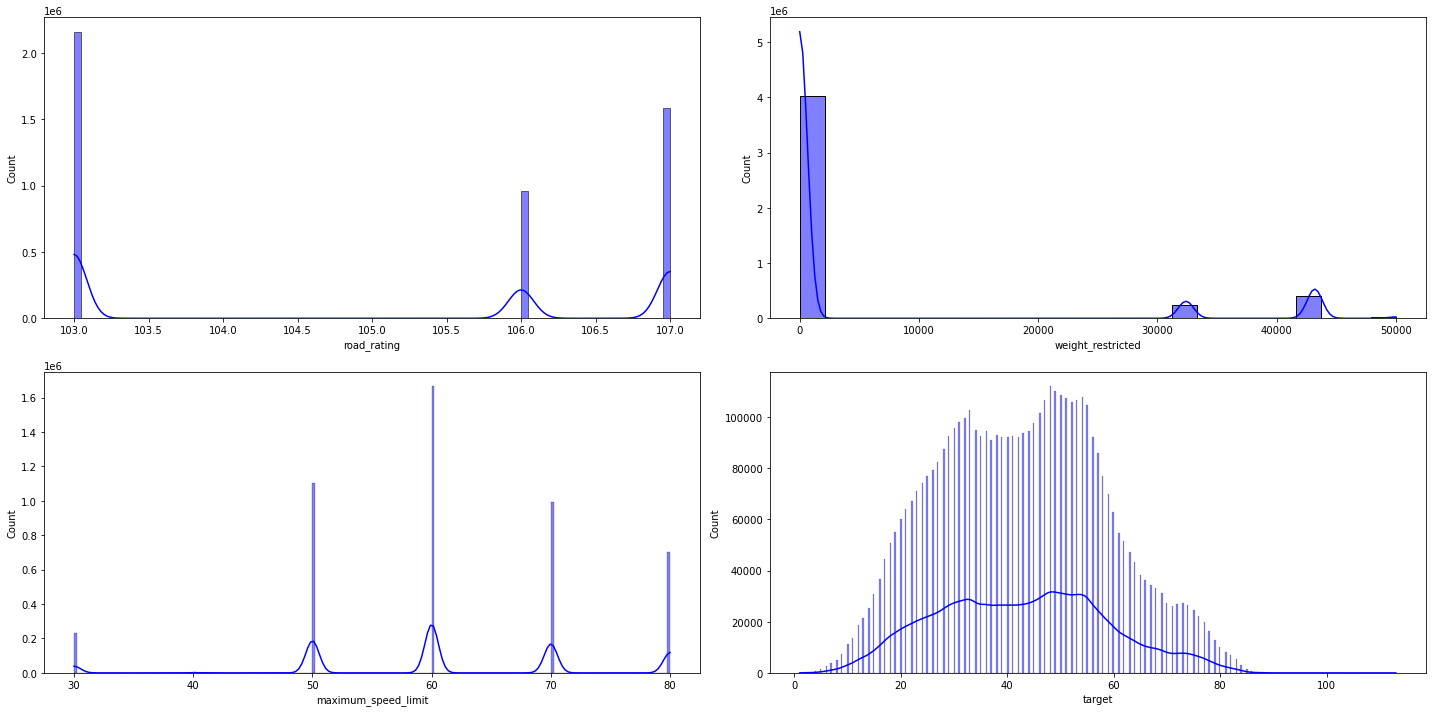

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20,10))

sns.histplot(x=train['road_rating'],kde=True,ax=axes[0][0], color='blue')
sns.histplot(x=train['weight_restricted'],kde=True,ax=axes[0][1], color='blue')
sns.histplot(x=train['maximum_speed_limit'],kde=True,ax=axes[1][0], color='blue')
sns.histplot(x=train['target'],kde=True,ax=axes[1][1], color='blue')

plt.tight_layout()
plt.show()

# road_rating = 3개의 값.
# weight_restricted = 대부분 0.
# maximum_speed_limit = 60이 대다수.
# 연속적인 데이터는 없음.

### Train / Test 세트 비교

- day_of_week: train 세트는 요일별 데이터가 일정, test 세트는 월화수가 비교적 많이 집계됨.
- base_hour: 일정함.
- road_in_use: 일정함.
- lane_count: train 세트는 2차로, test 세트는 3차로가 더 많음.
- road_rating: test 세트는 3등급 도로가 더 많이 집계됨.
- multi_linked: test 세트에는 1 값이 존재하지 않음.
- connect_code: test 세트에는 103 값이 존재하지 않음.
- maximum_speed_limit: test 세트에는 40이 존재하지 않음.
- weight_restricted: 일정함.
- road_type: 일정함.
- start_turn_restricted: 일정함.
- end_turn_restricted: 일정함.

/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matp

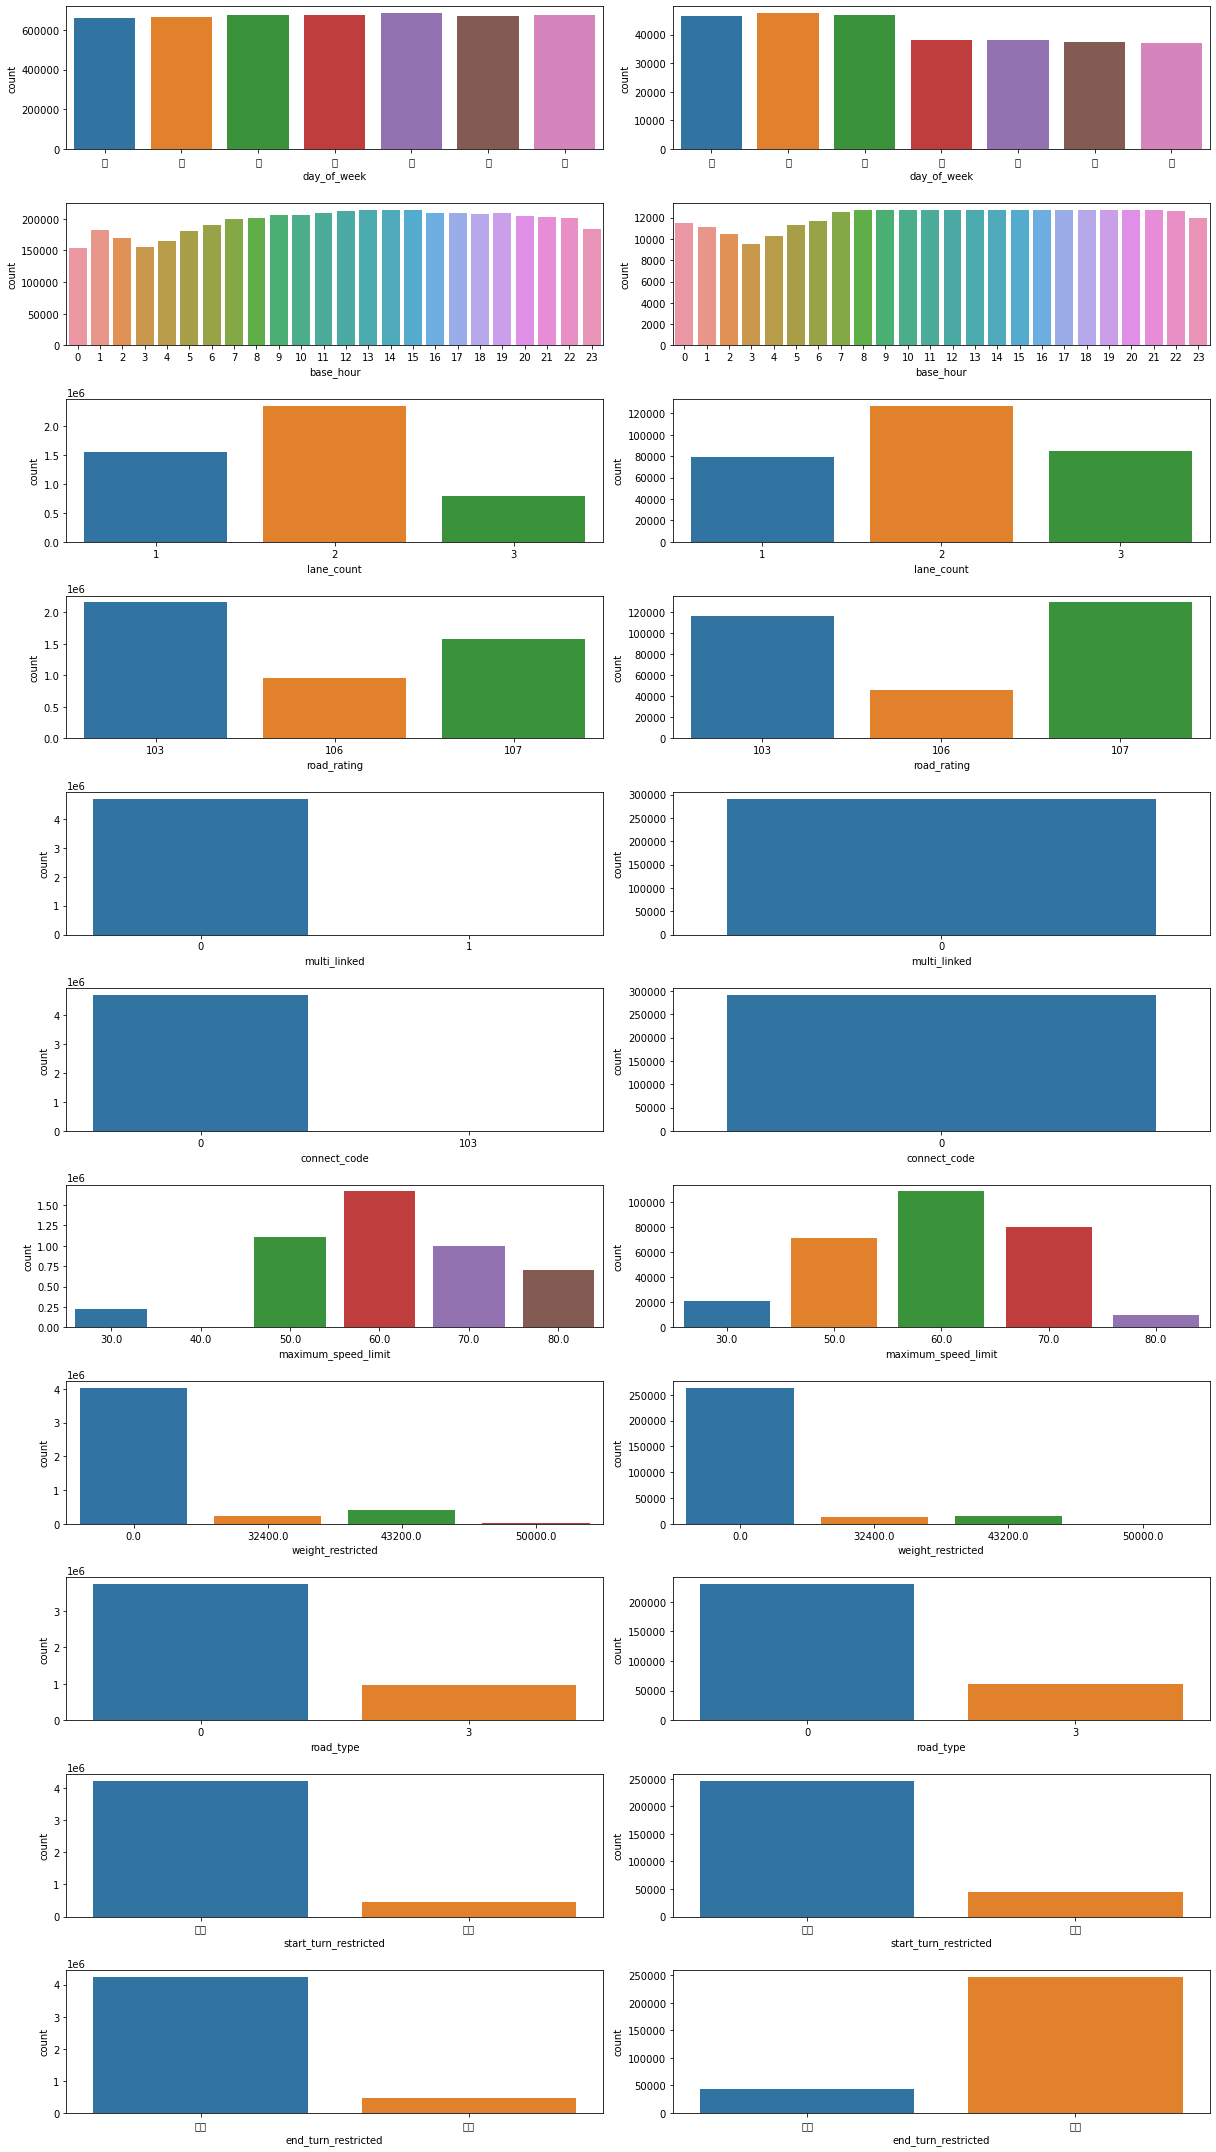

In [16]:
date_order = ['월','화','수','목','금','토','일']

fig, axes = plt.subplots(11, 2, figsize=(17,30))

sns.countplot(x='day_of_week', data=train, ax=axes[0][0],order=date_order)
sns.countplot(x='day_of_week', data=test, ax=axes[0][1],order=date_order)
sns.countplot(x='base_hour', data=train, ax=axes[1][0])
sns.countplot(x='base_hour', data=test, ax=axes[1][1])
sns.countplot(x='lane_count', data=train, ax=axes[2][0])
sns.countplot(x='lane_count', data=test, ax=axes[2][1])
sns.countplot(x='road_rating', data=train, ax=axes[3][0])
sns.countplot(x='road_rating', data=test, ax=axes[3][1])
sns.countplot(x='multi_linked', data=train, ax=axes[4][0])
sns.countplot(x='multi_linked', data=test, ax=axes[4][1])
sns.countplot(x='connect_code', data=train, ax=axes[5][0])
sns.countplot(x='connect_code', data=test, ax=axes[5][1])
sns.countplot(x='maximum_speed_limit', data=train, ax=axes[6][0])
sns.countplot(x='maximum_speed_limit', data=test, ax=axes[6][1])
sns.countplot(x='weight_restricted', data=train, ax=axes[7][0])
sns.countplot(x='weight_restricted', data=test, ax=axes[7][1])
sns.countplot(x='road_type', data=train, ax=axes[8][0])
sns.countplot(x='road_type', data=test, ax=axes[8][1])
sns.countplot(x='start_turn_restricted', data=train, ax=axes[9][0])
sns.countplot(x='start_turn_restricted', data=test, ax=axes[9][1])
sns.countplot(x='end_turn_restricted', data=train, ax=axes[10][0])
sns.countplot(x='end_turn_restricted', data=test, ax=axes[10][1])

plt.tight_layout()
plt.show()

#### train과 test의 도로명 비교

- train에 집계된 도로가 더 많음.

/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52272 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47196 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44256 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matp

/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 52272 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 47196 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44256 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/bac

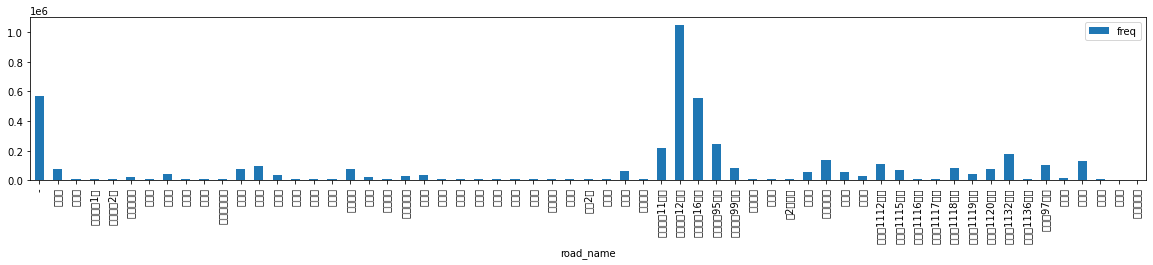

In [17]:
train1 = train.copy()
train1['freq'] = train1.groupby('road_name')['road_name'].transform('count')
train1 = train1[['road_name','freq']]
train1 = train1.groupby('road_name').mean().reset_index()
train1.plot.bar(x='road_name',y='freq',figsize=(20,3))
plt.show()

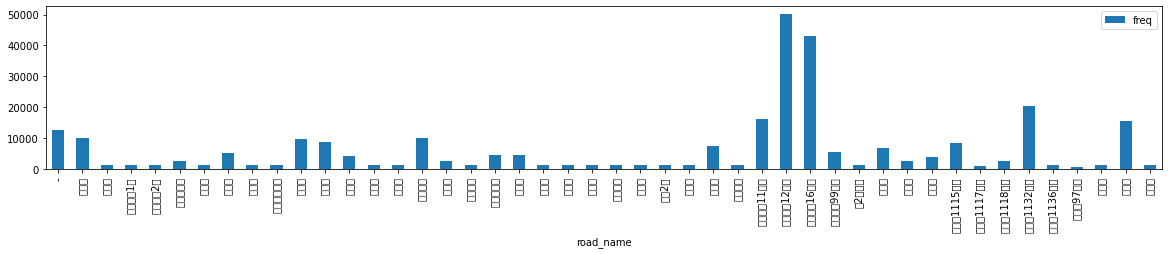

In [18]:
test1 = test.copy()
test1['freq'] = test1.groupby('road_name')['road_name'].transform('count')
test1 = test1[['road_name','freq']]
test1 = test1.groupby('road_name').mean().reset_index()
test1.plot.bar(x='road_name',y='freq',figsize=(20,3))
plt.show()

In [19]:
# 그룹화
train_date = train[['base_date','target']]
train_date = train_date.groupby('base_date').mean().reset_index()

train_time = train[['base_hour','target']]
train_time = train_time.groupby('base_hour').mean().reset_index()

train_day = train[['day_of_week','target']]
train_day = train_day.groupby('day_of_week').mean()
train_day = train_day.reindex(['월','화','수','목','금','토','일']).reset_index()

train_name = train[['road_name','target']]
train_name = train_name.groupby('road_name').mean().reset_index()

### 추이 그래프

- base_date = 2022년 7월 기준 교통량 증가.
- base_hour = 00시-05시,18시-24시 교통량 감소, 05시-18시 교통량 증가 (차이가 큼).
- day_of_week = 금요일 교통량 증가, 주말 교통량 감소 (큰차이 없음).
- road_name = -로 기록된 null값이 존재함.

findfont: Font family ['Apple Gothic'] not found. Falling back to DejaVu Sans.
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44552 missing from current font.
  font.set_text(s,

/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44552 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/bac

/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 52392 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 53468 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/zudy-b/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44540 missing from current font.
  font.set_text(s, 0, flags=flags)


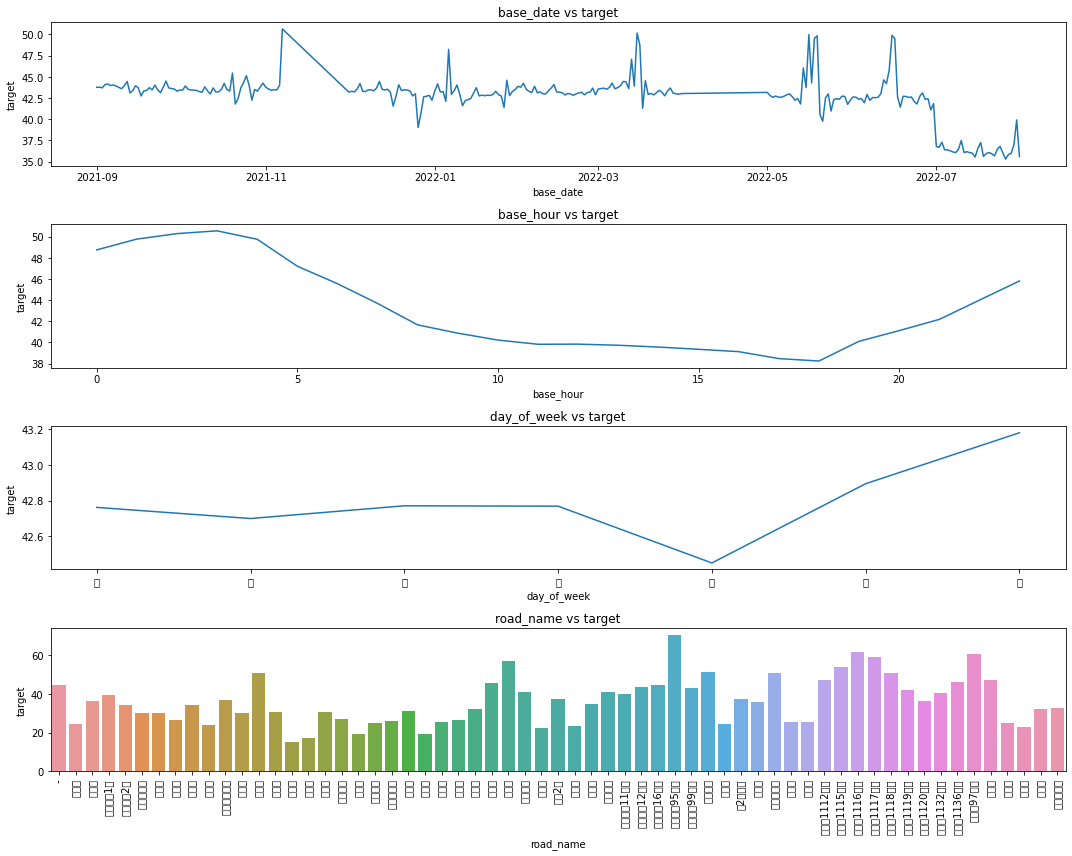

In [20]:
fig, axes = plt.subplots(4, figsize=(15,12))

sns.lineplot(x='base_date',y='target',data=train_date,ax=axes[0]).set(title='base_date vs target')
sns.lineplot(x='base_hour',y='target',data=train_time,ax=axes[1]).set(title='base_hour vs target')
sns.lineplot(x='day_of_week',y='target',data=train_day,ax=axes[2]).set(title='day_of_week vs target')
sns.barplot(x='road_name',y='target',data=train_name,ax=axes[3]).set(title='road_name vs target')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [21]:
train['year']= train['base_date'].dt.year
train['month']= train['base_date'].dt.month
train['day']= train['base_date'].dt.day